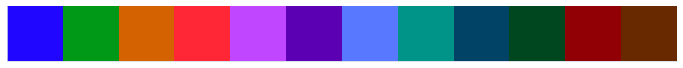

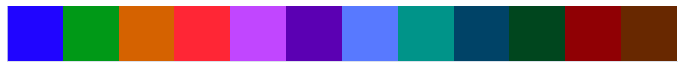

In [1]:
#constellate: setup

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc
import rho_plus

IS_DARK = False
theme, cs = rho_plus.mpl_setup(IS_DARK)
plt.style.use(theme)
sns.palplot(cs)

IS_DARK = False
theme, cs = rho_plus.mpl_setup(IS_DARK)
plt.style.use(theme)
sns.palplot(cs)

# Computing Fibonacci Numbers

The Fibonacci sequence is one of the most famous in mathematics. It begins with what we'll call the zeroth term[^1], $F(0) = 0$, and $F(1) = 1$. It is then defined recursively, so $F(n) = F(n-1) + F(n-2)$. It begins 0, 1, 1, 2, 3, 5, 8, 13, and so on.

How can we compute an arbitrary value of the Fibonacci series $F(n)$ as quickly as possible? This simple-sounding question provides a fascinating look into some very important topics in math and computer science. Even though computing the 10 billionth Fibonacci number has no practical value I'm aware of, the techniques we will explore in our attempt to get there are incredibly useful and worth knowing, and it's rather remarkable that such a variety of mathematics can lurk behind a simple-sounding problem like this one.

Let's get started!

[^1]: One irksome inconsistency in the Fibonacci sequence is how the terms are numbered. Some works start with $F(1) = 0$, others $F(1) = 1$ without a zeroth term, and it's just a headache all around. We'll use $F(0) = 0$ because for programming it's nice to have zero-indexing and because it lets us simply say $F(n) = n$ when $n \le 1$.

## The Naïve Approach

The formal definition of the Fibonacci sequence looks something like this:

$$
F(n) = \begin{cases}
0\ & n = 0 \\
1\ & n = 1 \\ 
F(n-1) + F(n-2) & n \ge 2
\end{cases}
$$

Let's just translate this directly into computer code and see how that goes.

As you can see, this is a relatively simple start. This is a pretty common introductory programming problem to introduce recursion, after all.

Unfortunately, there's a reason I only show Fibonacci number 30 instead of ten billion like I was talking about before. This is pretty fast up until around 30 on my machine (which takes only a second to compute), but then it slows down dramatically. $F_{100}$ would take a very, very long time using this method, longer than my computer can easily handle. Let's see why by looking deeper into this algorithm.

In [2]:
def naïve_fib(n):
    if n <= 1:
        return n
    else:
        return naïve_fib(n - 1) + naïve_fib(n - 2)

naïve_fib(30)

832040

Let's call $T(n)$ the number of arithmetic operations we need to compute $F(n)$. $T(0) = T(1) = 0$, because those values are given to us. $T(2) = 1$, because we need to add $F(0)$ and $F(1)$. $T(3) = 2$, because we need to compute $F(2)$ and then add it to $F(1)$. In general, we have that $T(n) = T(n-1) + T(n-2) + 1$: we need to compute the two numbers below the one we want and then add them together. The $T(n)$ sequence bears a striking resemblance to the Fibonacci sequence if you compare the definitions—this is a good example of how the Fibonacci sequence or similar sequences pop up in analyzing recursive algorithms.[^1]

I've graphed $T(n)$ for $n$ from 0 to 50. Note the scale on the y-axis, from 0 to 20 billion! $T_n$ grows exponentially, and gets really big really fast. Clearly this won't be a viable way of computing large Fibonacci numbers.

[^1]: A famous example is the Euclidean algorithm for computing the greatest common denominator, which has its worst performace for consecutive Fibonacci numbers.

Text(0, 0.5, '$T(n)$')

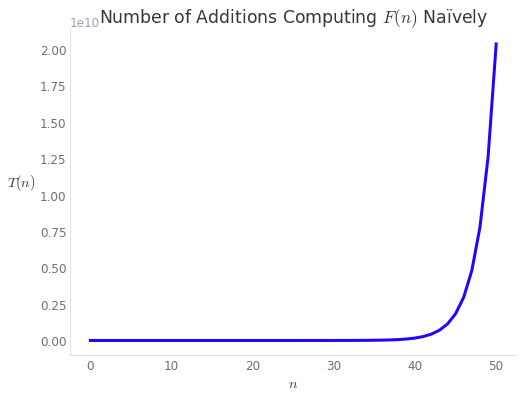

In [3]:
nn = np.arange(51)

tt = [0, 0]

for _ in range(len(nn) - 2):
    tt.append(tt[-1] + tt[-2] + 1)

tt = np.array(tt)

plt.plot(nn, tt)
plt.title('Number of Additions Computing $F(n)$ Naïvely')
plt.xlabel('$n$')
plt.ylabel('$T(n)$', ha='right', rotation=0)

We can see how evaluating a single Fibonacci number fans out into evaluating more and more numbers below it. This is enormously wasteful: we evaluate $F(2)$ three times, for example. At most, to evaluate $F(5)$, we should need to evaluate every Fibonacci number below it. We're doing worse than that!

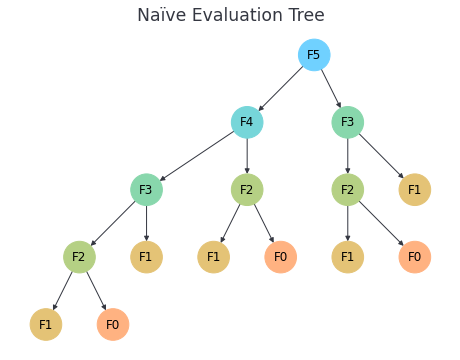

In [4]:
import networkx as nx
from matplotlib.colors import rgb2hex
from networkx.drawing.nx_pydot import graphviz_layout

g: nx.DiGraph = nx.DiGraph()

N = 5

node_colors = [rgb2hex(rgb) for rgb in cc.m_CET_I2(np.linspace(0, 1, N + 1))]

def make_node(parent_name, n):
    name, label = (f'F({n})_{parent_name}', f'F{n}')
    g.add_node(name, label=label, color=node_colors[N - n], fontcolor='#222222')
    return (name, label)
    

curr_nodes = [make_node('', N)]
while curr_nodes:
    new_nodes = []
    for name, label in curr_nodes:
        n = int(label[1:])
        if n >= 2:
            for i in (1, 2):
                new_name, new_label = make_node(name, n - i)
                g.add_edge(name, new_name)            
                new_nodes.append((new_name, new_label))            
    curr_nodes = new_nodes

pos = graphviz_layout(g, prog='dot')
fig, ax = plt.subplots()
ax.set_title('Naïve Evaluation Tree')
nx.draw_networkx(g, pos=pos, labels={n: label for n, label in g.nodes('label')}, node_color=[color for n, color in g.nodes('color')], node_size=1000, edge_color=plt.rcParams['text.color'], ax=ax)
sns.despine(fig, bottom=True, left=True)

## Memoization, the Easy Way

The easiest solution to this problem is called *memoization*: we create a lookup table that avoids redoing Fibonacci numbers we've already computed. 

Python has a built-in solution for this, conveniently enough, so it takes just two lines of code to upgrade our program.

Now we can compute $F(1000)$ faster than we computed $F(30)$ earlier![^1]

[^1]: If you're more used to other programming languages, you might wonder why there aren't any issues storing a number as big as $F(1000)$. Python integers are actually arbitrary-size by default, so there's no worries about running out of space.

In [5]:
from functools import lru_cache

# None means "store as many values as possible"
@lru_cache(None)
def memoized_fib(n):
    if n <= 1:
        return n
    else:
        return memoized_fib(n - 1) + memoized_fib(n - 2)

memoized_fib(1000)

43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875

Now we only compute each Fibonacci number once. Our evatuation tree looks something like this, where we've cut out all of the duplicate nodes. Each number starting from $F_2$ requires doing one addition (and two lookups, but lookups are fast), so we can compute $F_n$ using $n - 2$ additions.

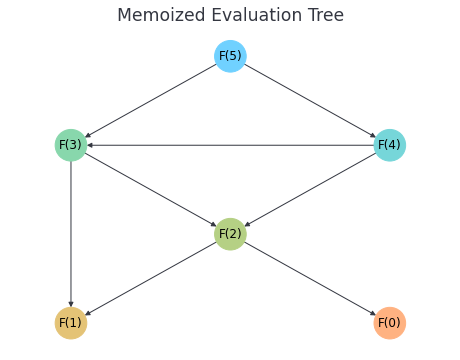

In [6]:
import networkx as nx
from matplotlib.colors import rgb2hex

g: nx.DiGraph = nx.DiGraph()

N = 5

node_colors = [rgb2hex(rgb) for rgb in cc.m_CET_I2(np.linspace(0, 1, N + 1))]

def make_node(parent_name, n):
    name, label = (f'F({n})', f'F({n})')
    g.add_node(name, label=label, color=node_colors[N - n], fontcolor='#222222')
    return (name, label)
    

curr_nodes = [make_node('', N)]
while curr_nodes:
    new_nodes = []
    for name, label in curr_nodes:
        n = int(label[2:-1])
        if n >= 2:
            for i in (1, 2):
                new_name, new_label = make_node(name, n - i)
                g.add_edge(name, new_name)            
                new_nodes.append((new_name, new_label))            
    curr_nodes = new_nodes

node_pos = [
    (100, 200),
    (150, 140),
    (50, 140),
    (100, 80),
    (50, 20),
    (150, 20)
]
pos = {n: xy for n, xy in zip(g, node_pos)}
memo_fig, ax = plt.subplots()
ax.set_xlim(30, 170)
ax.set_ylim(0, 220)
ax.set_title('Memoized Evaluation Tree')
nx.draw_networkx(g, pos=pos, labels={n: label for n, label in g.nodes('label')}, node_color=[color for n, color in g.nodes('color')], node_size=1000, ax=ax, edge_color=plt.rcParams['text.color'])
sns.despine(memo_fig, bottom=True, left=True)

## Dynamic Programming

If we try to evaluate `memoized_fib(10_000)`, we get a strange error:

```python
---------------------------------------------------------------------------
RecursionError                            Traceback (most recent call last)
/home/nicholas/programs/constellations/fast-fibonacci/fast-fib.ipynb Cell 15 in <cell line: 1>()
----> 1 memoized_fib(10_000)

/home/nicholas/programs/constellations/fast-fibonacci/fast-fib.ipynb Cell 15 in memoized_fib(n)
      7     return n
      8 else:
----> 9     return memoized_fib(n - 1) + memoized_fib(n - 2)

/home/nicholas/programs/constellations/fast-fibonacci/fast-fib.ipynb Cell 15 in memoized_fib(n)
      7     return n
      8 else:
----> 9     return memoized_fib(n - 1) + memoized_fib(n - 2)

    [... skipping similar frames: memoized_fib at line 9 (1483 times)]

/home/nicholas/programs/constellations/fast-fibonacci/fast-fib.ipynb Cell 15 in memoized_fib(n)
      7     return n
      8 else:
----> 9     return memoized_fib(n - 1) + memoized_fib(n - 2)

RecursionError: maximum recursion depth exceeded
```

What's going on?

### Stack Overflow (not the site)

When a function calls a function, it creates a *stack* of evaluations. Imagine an evaluation tree like the one before, but for $F(10,000)$. We call `memoized_fib(10_000)`, which calls `memoized_fib(9999)` and `memoized_fib(9998)`, and so on all the way down to 0 and 1. This stack takes up memory (we need to store which function call to return to when we're done evaluating this one, for each of these calls), and it looks an awful lot like an infinite loop: Python can't deduce that this will stop at some point. To prevent stack overflow (running out of memory on this stack of function calls) and infinite loops, there's a recursion limit that CPython (the standard Python implementation) enforces: a maximum number of function calls before a function returns a value. We've just hit that limit.

We could change this limit, but eventually we'd run out of memory instead. A better solution is what is known, somewhat misleadingly, as *dynamic programming*.

In [7]:
import sys
print(sys.getrecursionlimit())

3000


### Dynamic Programming In Action

Dynamic programming (DP) actually predates computer programming—here *program* means a schedule or plan of action, because dynamic programming can be very useful for things like scheduling. (Dynamic was chosen, and I'm being serious here, because it sounded good and was something that the US government officials funding its research wouldn't think of as too mathy.)

The idea is pretty simple. Instead of going down from $F(10,000)$ down to $F(0)$ and saving results as we go, we go up from $F(0)$ and continually fill in our table of values.

We start with

|$n$|$F(n)$|
|---|-----|
|0|0|
|1|1|
|2| |
|3| |
|...|...|

and, each step, fill in the next value using the previous two. Our next step makes the table look like this:

|$n$|$F(n)$|
|---|-----|
|0|0|
|1|1|
|2|**1**|
|3| |
|...|...|

This will perform exactly the same number of additions as a memoized approach, and is theoretically equivalent. The advantage is that we won't run into any issues with stack size, because we're just storing the answers instead of storing a bunch of data about the function calls.

In classical DP, we store every value. The Fibonacci sequence has the convenient property that it only depends on the previous two values, so we don't actually need to store every value. We can just store the most recent two. This will look something like this in the middle of computing $F(10,000)$:

|$n$|$F(n)$|
|---|----:|
|...|...|
|20|6765|
|21|10946|
|22|**17711**|
|...|...|

Although the number of additions we perform will be the same, in practice this tends to be faster than recursion. Every time you call a function in Python, Python has to look up what code to run in a table of functions, and this cuts out that unnecessary step. Let's see it in action!

Much better! Now we can compute $F(500,000)$ without breaking a sweat: this took a little over 2 seconds on my machine.

In [8]:
def dp_fib(n):
    if n < 2:
        return n


    prev, curr = 0, 1
    i = 1  
    while i < n:
        # our current number gets demoted to the previous number
        # and our new current number is the sum of the last two
        prev, curr = curr, prev + curr
        i += 1

    return curr

# this is a *very* big number (104,494 decimal digits), so we're just going to print its last several digits
dp_fib(500_000) % 1_000_000_000

780453125

### Tail Call Recursion

The reason Python has a stack of function calls is to deal with the case of a function that calls another function and then does something with the result before returning it:

```python
def fact(n):
    """The factorial function."""
    if n == 0:
        return 1
    else:
        return n * fact(n - 1)
```

Computing `fact(4)` looks like this:

```python
fact(4)
= 4 * fact(3)
= 4 * (3 * fact(2))
= 4 * (3 * (2 * fact(1)))
= 4 * (3 * (2 * (1 * fact(0))))
= 4 * (3 * (2 * (1 * 1)))
= 4 * (3 * (2 * 1))
= 4 * (3 * 2)
= 4 * 6
= 24
```

Python has to store a lot of information for each of those parentheses so it knows to go back to the right place after evaluating each call.

Now let's look at a different function that does the same thing:

```python
def fact2(n, curr_value=1):
    if n == 0:
        return curr_value
    else:
        return fact2(n - 1, curr_value * n)
```

Now evaluating this looks a little different:
```python
fact2(4, 1)
= fact2(3, 4)
= fact2(2, 12)
= fact2(1, 24)
= fact2(0, 24)
= 24
```

There's no need to remember what the previous function calls were: at each step, we have all of the information we need to get the answer.

This structure is possible whenever the only `return` statements your function has are just a single expression. It's called *tail-call recursion*, because all of the recursion happens at the tail of the function.

The stack is unnecessary when you're dealing with tail-call recursion. It's possible to automatically rewrite it in terms of a `while` loop like so:

```python
def fact3(n, curr_value=1):
    while n != 0:
        curr_value = curr_value * n
        n = n - 1

    return curr_value

# the recursive version, for reference
def fact2(n, curr_value=1):
    if n == 0:
        return curr_value
    else:
        return fact2(n - 1, curr_value * n)
```

The values that `n` and `curr_value` take in `fact3` will exactly match the sequence of function calls in evaluating `fact2`. 

Why go down this rabbit hole when we already had an iterative version that worked for the Fibonacci sequence? Well, I'll come clean—this is all an excuse to gripe that CPython does not do this kind of tail-call optimization automatically. The `tail_call_fib` function here, if it were in a language like Haskell or Scheme, would be automatically rewritten into something very similar to the DP solution, but it isn't here. If you're working in a compiled language, sometimes you can even get smarter than that and automatically rewrite functions into a tail-call-recursive equivalent. In Haskell, this function won't stack overflow:

```haskell
fact 0 = 1
fact n = n * fact (n - 1)
```

Haskell can see that this can be rewritten into a tail-call-recursive form and then rewritten into a loop. Pretty cool, huh?

On the side we have what tail call recursion for the Fibonacci sequence would look like. Hopefully the comparison between the iterative and recursive solutions shows how similar they really are.

In [9]:
def tail_call_fib(n):
    if n < 2:
        return n
                    
    def f(prev, curr, i):
        if i == n:
            return curr
        else:
            return f(curr, prev + curr, i + 1)

    return f(0, 1, 1)


# for comparison, the previous DP solution
def dp_fib(n):
    if n < 2:
        return n

    # note how this exactly matches the f(0, 1, 1) initial call above
    prev, curr, i = 0, 1, 1    
    while i < n:
        prev, curr = curr, prev + curr
        i += 1

    return curr

tail_call_fib(20) == dp_fib(20)

True

## Breaking Out the Big Guns: Applying Linear Algebra

We've essentially exhausted the speed gains we can get with our current approach. Lucky for us, computing a specific Fibonacci number doesn't actually require computing all of the previous ones! Our need for speed can only be satiated by changing our approach completely. Let's see how we might do that.

Consider other sequences besides the Fibonacci sequence that satisfy the recurrence equation $S(n) = S(n - 1) + S(n - 2)$. For example, another sequence could start 3, 1, 4, 5, 9, etc. I'll note two facts about these sequences:
 - Multiplying all of the values in the sequence by a constant preserves the recurrence. For example, the sequence 0, 2, 2, 4, 6, 10, ... is the Fibonacci sequence doubled, and it obeys the rule as well.
 - Adding two sequences to each other produces another valid sequence. For example, we can add the Fibonacci sequence to the one that started 3, 1, 4, ... to get 3, 2, 5, 7, 12, ..., and this new sequence still obeys the rule.

These two properties—preserving constant multiplication and preserving addition—have a special name. We say that the Fibonacci recurrence is *linear*. If you have two lines, and you add them together (e.g., applying this operation), you still get a line, hence the name.

Linearity *rocks*. Linear algebra provides us a fantastically useful set of tools that let us analyze the sequence in more detail, and this will lead us to far more efficient approaches for computing $F(n)$.

(A note to the reader: I'll be moving pretty quickly through the basics of linear algebra so as not to bore people who are more familiar with it, so if this is completely new to you it might be a little overwhelming. [3blue1brown](https://www.3blue1brown.com/topics/linear-algebra) has excellent resources for deepening your understanding if you want that, and if you're interested in programming and/or math it's highly recommended study material.)

### *The Matrix* (with slightly fewer action sequences)

Because we need two consecutive values to find the next value in the Fibonacci sequence, we can think of a single "step" as going from a pair of numbers $(F(n), F(n-1))$ to $(F(n+1), F(n))$. 

I'll skip the derivation, but as it turns out a linear transformation on a pair of numbers $(x, y)$ can always be expressed as $ax + by$, where $a$ and $b$ are some constants. For our transformations, we have

$$
\providecommand{\cone}[1]{\textcolor{147eb3}{#1}}
\providecommand{\ctwo}[1]{\textcolor{29a634}{#1}}
\providecommand{\cthree}[1]{\textcolor{d1980b}{#1}}
\providecommand{\cfour}[1]{\textcolor{d33d17}{#1}}
\providecommand{\cfive}[1]{\textcolor{9d3f9d}{#1}}
\providecommand{\csix}[1]{\textcolor{00a396}{#1}}
\providecommand{\cseven}[1]{\textcolor{db2c6f}{#1}}
\providecommand{\ceight}[1]{\textcolor{8eb125}{#1}}
\providecommand{\cnine}[1]{\textcolor{946638}{#1}}
\providecommand{\cten}[1]{\textcolor{7961db}{#1}}
$$

$$
\begin{aligned}
F(n+1) &= \cone{1} F(n) + \cone{1} F(n - 1) \\
F(n)   &= \cone{1} F(n) + \cone{0} F(n - 1) \\
\end{aligned}
$$

These constants are the essence of the operation we're performing. Because they're the key, we can take them out and put them in a *matrix*:

$$
\begin{pmatrix}
F(n+1) \\
F(n)
\end{pmatrix} = 
\begin{pmatrix}
1 & 1 \\
1 & 0 \\
\end{pmatrix}
\begin{pmatrix}
F(n) \\
F(n - 1)
\end{pmatrix}
$$

The only thing that looks really different is that we stacked $F(n)$ and $F(n-1)$ on top of each other instead of separating them horizontally like before. The constants and the left-hand side should look very similar to before.

Matrix multiplication is simply going from this representation to the equations above. Specifically, you take rows from the first matrix and columns from the second matrix and multiply together all of the terms—the sum of those products is the value at that cell. Let's look at one example to see what this looks like.

On the side we have a sample matrix multiplication. Here $A$ is a $2 \times 2$ matrix, and B is a $2 \times 3$ matrix (rows $\times$ columns). Matrices only multiply when the rows of the first match up with the columns of the second. The number of rows is given by the number of rows in the left matrix, and the number of columns is given by the number of columns in the right matrix. Succinctly, we have that 

$$(m \times n)(n \times p) \Rightarrow m \times p$$

Here, we have a $\cone{2} \times \ctwo{2}$ matrix times a $\ctwo{2} \times \cthree{3}$ matrix, which gives us a $\cone{2} \times \cthree{3}$ matrix. Note that $BA$ isn't even a valid multiplication, because $B$ has 3 values per row but $A$ has 2 values per column. Matrix multiplication is not commutative! (It is associative: $ABC = (AB)C = A(BC)$.)

If this is new to you, take a second to look at what's being multiplied by what. To get the cell at row $i$ and column $j$ of the output, we take row $i$ from $A$ and column $j$ from $B$, multiply them together pairwise, and then sum them up.

If we think of matrices as transformations, like the Fibonacci stepping, then the shape of the matrix tells us how many values it takes in and how many it spits out. $B$ is a $2 \times 3$ matrix, so it can be multiplied by a $3 \times 1$ list of numbers to get a $2 \times 1$ of outputs: it takes three inputs and gives you two back. The recurrence $F(n + 1) = F(n) + F(n - 1)$ is represented by $\begin{pmatrix} 1 & 1 \end{pmatrix}$, a $1 \times 2$ matrix. The full version that gives you $F(n + 1)$ and $F(n)$ is just this row stacked on top of another row describing how we get $F(n)$.

#constellate: latex
$$
\begin{aligned}
A &= \begin{pmatrix} \cone{3} & \cone{1} \\ \ctwo{4} & \ctwo{2} \\ \end{pmatrix} \\
B &= \begin{pmatrix} \cthree{5} & \cfour{7} & \cfive{9} \\ \cthree{6} & \cfour{10} & \cfive{8} \\ \end{pmatrix} \\
AB &= \begin{pmatrix} \cone{3} & \cone{1} \\ \ctwo{4} & \ctwo{2} \end{pmatrix} 
\begin{pmatrix} \cthree{5} & \cfour{7} & \cfive{9} \\ \cthree{6} & \cfour{10} & \cfive{8} \\ \end{pmatrix} \\
&= \begin{pmatrix}
\cone{3} \times \cthree{5} + \cone{1} \times \cthree{6} & \cone{3} \times \cfour{7} + \cone{1} \times \cfour{10} & \cone{3} \times \cfive{9} + \cone{1} \times \cfive{8} \\
\ctwo{4} \times \cthree{5} + \ctwo{2} \times \cthree{6} & \ctwo{4} \times \cfour{7} + \ctwo{2} \times \cfour{10} & \ctwo{4} \times \cfive{9} + \ctwo{2} \times \cfive{8} \\
\end{pmatrix} \\
&= \begin{pmatrix}
21 & 31 & 35 \\
32 & 48 & 52 \\
\end{pmatrix} \\
\end{aligned}
$$

### Matrix Exponentiation

Let's call our matrix $\begin{pmatrix} 1 & 1 \\ 1 & 0 \\ \end{pmatrix}$ that represents a single iteration of the Fibonacci recurrence $M$. What can we do now that we have $M$ as a matrix?

Well, let's start with our initial values $V = \begin{pmatrix}1 \\ 0\end{pmatrix}$. We have that 
$$MV = \begin{pmatrix}2 \\ 1\end{pmatrix}$$

All is as expected: we've moved along to the next value of the Fibonacci sequence.[^1] Doing it more, we get 

$$
\begin{aligned}
M(MV) &= \begin{pmatrix}3 \\ 2\end{pmatrix} \\
M(M(MV)) &= \begin{pmatrix}5 \\ 3\end{pmatrix} \\
M(M(M(MV))) &= \begin{pmatrix}8 \\ 5\end{pmatrix} \\
\end{aligned}
$$

[^1]: If you're new to matrices, try doing these calculations yourself and verifying my work.

In general, we seem to have that 

$$
M^n V = \begin{pmatrix} F(n + 1) \\ F(n) \end{pmatrix}
$$

(Remember, order matters but we can remove the parentheses: matrix multiplication is associative but not commutative.)

So now we have a new question: how can we compute $M^n$ efficiently?

## Naïve Matrix Exponentiation

The simplest approach is simply to do $M \times M \times M \times \dots$ as many times as we need. Note that the standard matrix multiplication approach I outlined above requires two multiplications and an addition per cell of the output when you're multiplying a 2x2 matrix by another 2x2 matrix. This means that it requires eight multiplications and four additions to do what we were doing earlier with a single addition!

I'll put the code here, but this is a significant downgrade over our previous approaches. 

I'll also mention that one of the nice things about using linear algebra tools is that you can use someone else's code. I'm only implementing multiplication myself for illustrative purposes: you should definitely be using a library like `numpy` in Python to do linear algebra operations—it'll be faster than anything you write, and less work for you to boot!

In [10]:
def multiplynxn(m1, m2):
    """Multiplies two matrices as a list of lists."""
    # each matrix is of the form 
    # [
    #   [a, b],
    #   [c, d]
    # ]

    # row length must match column length
    m, n = len(m1), len(m1[0])
    p = len(m2[0])
    assert(n == len(m2))

    answer = [
        [None for _ in range(p)]
        for _ in range(m)
    ]

    for row in range(m):
        for col in range(p):
            value = 0
            for i in range(n):
                value += m1[row][i] * m2[i][col]
            answer[row][col] = value

    return answer

def naïve_matrix_fib(n):
    if n < 2:
        return n

    m = [
        [1, 1],
        [1, 0]
    ]
    curr = m

    for _ in range(n - 1):
        curr = multiplynxn(m, curr)

    v = [
        [1],
        [0]
    ]
    return multiplynxn(curr, v)[1][0]

naïve_matrix_fib(1000)

43466557686937456435688527675040625802564660517371780402481729089536555417949051890403879840079255169295922593080322634775209689623239873322471161642996440906533187938298969649928516003704476137795166849228875

## Efficient Exponentiation: Beating the Schoolbook Method

Luckily for us[^1], we can do a *lot* better, and by efficiently exponentiating we can achieve a massive speedup over all of the previous approaches.

Efficient exponentiation works for anything where multiplication is associative. That means I'll use integers to explain the method.

[^1]: Not only is it it just plain convenient, but many cryptography algorithms rely on this fact!

Let's imagine we're trying to compute $2^4 = 16$. Our above approach computes

$$2 \times 2 \times 2 \times 2$$

which requires three multiplications. In general, it requires $n - 1$ multiplications to compute an $n^{th}$ power.

The trick is realizing that we don't have to just multiply by $2$ here. Here's a different approach:

$$
\begin{aligned}
2 \times 2 &= 4\\
4 \times 4 &= 16
\end{aligned}
$$

We've saved a multiplication by using $4$ twice!

OK, I'll admit this example is pretty lame. You probably didn't need me to tell you that $2^4 = 16$. But this approach scales far better than the old one.

For example, to compute $2^{32}$, we can use the following series of multiplications:

$$
\begin{aligned}
2 \times 2 &= 4 &= 2^2 \\
4 \times 4 &= 16 &= 2^4 \\
16 \times 16 &= 256 &= 2^8 \\
256 \times 256 &= 65,536 &= 2^{16} \\
65,536 \times 65,536 &= 4,294,967,296 &= 2^{32} \\
\end{aligned}
$$

The old approach required 31 multiplications—now we can do it in 5.

Each multiplication doubles the exponent, so in the best case we can compute $2^n$ in $\log_2 n$ multiplications. That's an exponential speedup over our old approach!

You might have a question at this point: how do we adapt this approach to work with exponents that aren't powers of two? How would we compute $2^{20}$, for example?

### A General Approach

We're now going to shift the problem a little. Instead of thinking about multiplications, we'll think about additions. When we multiply $2^a 2^b$, the result is $2^{a + b}$: the sum of the exponents. So we want to find an *addition chain* that starts at 1 and ends at our target exponent. An addition chain is a sequence of numbers, each of which is the sum of two previous numbers in the chain. 1 → 2 → 4 → 8 is one addition chain: another would be 1 → 2 → 3 → 5 → 8 (seems familiar somehow...).

Let's say we want to compute $2^{20}$. In other words, we want an addition chain for 20. As it turns out, getting the optimal addition chain for large numbers is very challenging—there are no clean algorithms for it. But we don't need a perfect approach that never fails to save a multiplication: we just want to do better than 1 + 1 + 1 + 1 + ... which is what we had before.

Powers of 2 are easy to make in addition chains. What if we can use that?

Specifically, let's start our chain by going 1 → 2 → 4 → 8 → 16, ending at the last power of 2 before 20. Adding the previous number to itself is the fastest our chain can grow, so this makes intuitive sense: we want to get close to 20 quickly to get a short chain. Now, is there any way to represent 20 as the sum of powers of 2?

### Binary Exponentiation

Representing a number as a sum of powers of two is exactly what binary does! We have that 

$$
\begin{aligned}
20 &&=\ &10100_2 \\
   &&=\ &1&&0&&1&&0&&0 \\
   &&=\ &1 \times 2^4 + &&0 \times 2^3 + &&1 \times 2^2 + &&0 \times 2^1 + &&0 \times 2^0 \\
   &&=\ &2^4 + 2^2 \\
\end{aligned}
$$

We just add up all of the powers of two that correspond to ones in binary. The number of ones, called the *Hamming weight*, will determine how efficient this becomes. Numbers right below a power of 2, like $15 = 1111_2$, require the most additions: powers of two require the fewest relative to their size.

The algorithm ends up as follows. To find $b^n$:
 - Compute $b^1, b^2, b^4$, up until the last power of 2 before $b^n$, computing each new term by squaring the previous term.. Store these powers in a list, call it `l`.
 - Set a working variable `product = 1`
 - For each bit of n: if it's a one, set `product = product * l[i]` where `2^i` is the place of the bit.
 - Return `product`

Here we have my generalized implementation of exponentiation by squaring. We'll be using it for more than just matrices, so it takes in a multiplication function and multiplicative identity: this means we can use whatever objects we want, so long as we implement multiplication and there's an equivalent to 1.

In [11]:
#constellate: setup
def exp_by_squaring(mul_fn, one, b, n):
    """Computes b ^ n using multiplication by squaring and a given multiplication function and identity."""
    n_binary = np.binary_repr(n)

    # b^1 = b for any b
    powers = [b]
    for _ in range(len(n_binary) - 1):
        # square the previous number and add it to the list
        powers.append(mul_fn(powers[-1], powers[-1]))

    # now powers is b^1, b^2, b^4, b^8, ... up until the power of two we need

    # reverse: change to most-to-least significant in order to match how we write numbers
    powers = powers[::-1]

    ans = one
    # loop through the powers and bits at the same time
    for power, bit in zip(powers, n_binary):
        # if the bit is 1, multiply by that power
        if bit == '1':
            ans = mul_fn(ans, power)
    return ans

In [12]:
def exp_by_squaring(mul_fn, one, b, n):
    """Computes b ^ n using multiplication by squaring and a given multiplication function and identity."""
    n_binary = np.binary_repr(n)

    # b^1 = b for any b
    powers = [b]
    for _ in range(len(n_binary) - 1):
        # square the previous number and add it to the list
        powers.append(mul_fn(powers[-1], powers[-1]))

    # now powers is b^1, b^2, b^4, b^8, ... up until the power of two we need

    # reverse: change to most-to-least significant in order to match how we write numbers
    powers = powers[::-1]

    ans = one
    # loop through the powers and bits at the same time
    for power, bit in zip(powers, n_binary):
        # if the bit is 1, multiply by that power
        if bit == '1':
            ans = mul_fn(ans, power)
    return ans

# compute 4^3
print(exp_by_squaring(lambda x, y: x * y, 1, 4, 3))
# compute 4*5
print(exp_by_squaring(lambda x, y: x + y, 0, 4, 5))

64
20


## A Truly Exponential Speedup

Let's use this in our matrix exponentiation algorithm. I'm using `numpy` matrices so it's easier to read: note that `@` is used for matrix multiplication (to distinguish it from element-wise multiplication).

We've really broken the barrier we were running into: this bad boy can handle computing $F(10,000,000)$ without breaking a sweat! Considering it has over 2 million decimal digits, I think that's pretty impressive. One thing I want to highlight is how useful linear algebra has been already. It provides a very useful common language for all sorts of different problems—if you can phrase your problem using matrices, chances are someone's already figured out how to solve it and written the code for you. Here, just by using a matrix to write things out, we've stumbled into a massive speedup.

Now that we've gone from on the order of $n$ operations to compute $F(n)$ to on the order of $\log n$, let's explore some alternatives to matrix exponentiation by squaring that might shave some time off.

In [13]:
import numpy as np
import math

# we use "dtype=object" because we want to use Python's integers, which have no size limit
def matrix_fib(n):
    if n < 2:
        return n
    m_to_the_n = exp_by_squaring(
        lambda x, y: x @ y, # the multiplication function
        np.eye(2, dtype=object), # generates the "eye"-dentity matrix with shape 2x2
        # the matrix we're exponentiating
        np.array([
            [1, 1],
            [1, 0]
        ], dtype=object),
        n)
    
    v = np.array([[1], [0]])
    return (m_to_the_n @ v)[1][0]

# just get the number of digits (adds significant runtime)
math.ceil(math.log10(matrix_fib(10_000_000))) + 1

2089878

In [14]:
#constellate: ignore
# def winograd2x2(m1, m2):
#     """Multiplies the 2x2 matrices (as flattened lists) using the Winograd form."""
#     a1, b1, c1, d1 = m1
#     a2, c2, b2, d2 = m2

#     u = (c1 - a1) * (c2 - d2)
#     v = (c1 + d1) * (c2 - a2)
#     w = a1 * a2 + (c1 + d1 - a1) * (a2 + d2 - c2)
#     return [
#         a1 * a2 + b1 * b2,
#         w + v + (a1 + b1 - c1 - d1) * d2,
#         w + u + (b2 + c2 - a2 - d2) * d1,
#         w + u + v
#     ]


# def matrix_fib(n):
#     if n < 2:
#         return n
#     return exp_by_squaring(winograd2x2, [1, 0, 0, 1], [0, 1, 1, 1], n)[1]

# x = matrix_fib(10_000_000)
# # just get the last couple digits
# x % 10_000_000

## Interlude: Checking Our Work

From now on, we're going to be using fast algorithms and computing very, very large numbers. When testing a new algorithm, how can we make sure we get the right answer if using our existing algorithms to check it becomes too slow?

I'll use a solution that harkens back to the days before calculators: checking remainders modulo some base. If you're doing a calculation by hand, and you want to check your work, one simple solution is to convert every number to its remainder when divided by, say, 9. (This has a simple formula: add up all of the digits and get the remainder of *that* divided by 9.) The final answer you get when doing this should be the remainder of the whole answer when divided by 9.

For example, if you add 115 + 257 = 372 and want to check your work:
 - $115 = 12 \times 9 + \mathbf{7}$. I'm writing out the full division, but you know this just by adding 1 + 1 + 5 = 7.
 - Similarly, 257 leaves remainder 5 when divided by 9: 2 + 5 + 7 = 14, and 1 + 4 = 5.
 - 7 + 5 is 12, which when divided by 9 leaves remainder 3.
 - Our full answer has remainder 3 as well: 3 + 7 + 2 = 12, and 1 + 2 = 3.

Note that we have a 1 in 9 chance of missing an error, because there's a 1 in 9 chance that our two remainders are the same even if the numbers are different.

Because we're not doing things by hand, we can choose a larger modulus: our actual numbers are so gargantuan that even working with remainders modulo 100,000 (i.e., taking the last five digits) gives a massive speedup.

[The Fibonacci sequence is an A-list celebrity in the world of integer sequences, so their remainders modulo different bases are well studied.](https://www.wikiwand.com/en/Pisano_period#/Fibonacci_integer_sequences_modulo_n) We don't want the numbers to cycle too often, and it'd be nice if $F(10,000), F(100,000)$, etc., all had different remainders. After a little searching, I'll go with taking remainders modulo 100,013. It takes 100,880 numbers for the remainders to start from 0 and 1 again, and that cycle covers 35,195 different numbers.

I've implemented a function to find $F(n) \mod 100,013$ on the right: it's just a slightly modified version of `matrix_fib` that uses smaller values and is much faster because of it.

In [15]:
#constellate: setup
def matrix_fib_modulo(n, m):
    """Finds F(n) modulo m."""

    if n < 2:
        return n
    m_to_the_n = exp_by_squaring(
        lambda x, y: (x @ y) % m, # the multiplication function, adjusted to include modulo
        np.eye(2), # generates the "eye"-dentity matrix with shape 2x2    
        np.array([
            [1, 1],
            [1, 0]
        ]),
        n)
    
    v = np.array([[1], [0]])
    return int((m_to_the_n @ v)[1][0])

# print(matrix_fib(100_000) % 100_013, matrix_fib_modulo(100_000, 100_013))
# print(matrix_fib(1_000_000) % 100_013, matrix_fib_modulo(1_000_000, 100_013))

In [16]:
def matrix_fib_modulo(n, m):
    """Finds F(n) modulo m."""

    if n < 2:
        return n
    m_to_the_n = exp_by_squaring(
        lambda x, y: (x @ y) % m, # the multiplication function, adjusted to include modulo
        np.eye(2), # generates the "eye"-dentity matrix with shape 2x2    
        np.array([
            [1, 1],
            [1, 0]
        ]),
        n)
    
    v = np.array([[1], [0]])
    return int((m_to_the_n @ v)[1][0])

print(matrix_fib(100_000) % 100_013, matrix_fib_modulo(100_000, 100_013))
print(matrix_fib(1_000_000) % 100_013, matrix_fib_modulo(1_000_000, 100_013))

48082 48082
52789 52789


## Binet's Formula

There is actually a closed-form formula for $F(n)$, meaning a formula that requires no recursion or iteration. Let's see how we can derive it using some more linear algebra.

### Diagonalization

The *identity matrix* is the matrix with all 1s on the main diagonal (top-left to bottom-right) and 0s everywhere else. Multiplying by the identity matrix always does nothing.

If instead of 1s we have different numbers on the main diagonal, with everything else still 0, multiplication does something interesting:

$$
\begin{aligned}
I &= \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \\
I^2 = I^3 = I^n &= I \\
D &= \begin{pmatrix} a & 0 \\ 0 & b \end{pmatrix} \\
D^2 &= \begin{pmatrix} a^2 & 0 \\ 0 & b^2 \end{pmatrix} \\
D^n &= \begin{pmatrix} a^n & 0 \\ 0 & b^n \end{pmatrix} \\
\end{aligned}
$$

I highly recommend working out $D^2$ for yourself if you aren't comfortable with the logic behind it. For *diagonal* matrices, it seems like exponentiation is a lot simpler than it is for generic matrices.

But the matrix $M = \begin{pmatrix} 1 & 1 \\ 0 & 1 \end{pmatrix}$ isn't diagonal. How can we apply this special case when our matrix doesn't fit it?

Call the *inverse* of a square matrix[^1] $M$, denoted $M^{-1}$, the matrix such that $M^{-1}M = MM^{-1} = I$. It's the equivalent of $\frac{1}{x}$ for real numbers.

Let's suppose we can find some matrix $P$ such that $M = PDP^{-1}$, where $D$ is a diagonal matrix.

If we expand out, for instance, $M^2$, a funny thing happens:
$$
\begin{aligned}
M &= PDP^{-1} \\
M^2 &= (PDP^{-1})(PDP^{-1}) \\
&= PD(P^{-1}P)DP^{-1} \\
&= PDIDP^{-1} \\
&= PDDP^{-1} \\
&= P(D^2)P^{-1}
\end{aligned}
$$

The extra copies of $P$ and $P^{-1}$ just vanish. In general, we have that $(PDP^{-1})^n = P(D^n)P^{-1}$. All of those cancellations save us a lot of work: recall that $D^n$ is relatively easy to compute. So, for the price of just two extra multiplications, we can use this representation, called a *diagonalization* of $M$, to efficiently compute $M^n$.

[^1]: Exercise for the reader: why do I specify square?

### Diagonalizing M

Diagonalization is a big topic[^1], but we'll try to diagonalize $M$ here without too much magic. Strap in!

We want to find matrices $P$ and $D$ such that $PDP^{-1} = \begin{pmatrix}1 & 1 \\ 1 & 0 \end{pmatrix}$ and $D$ is diagonal. Let's do some rearranging:

$$
\begin{aligned}
PDP^{-1} &= M \\
PDP^{-1}P &= MP \\
PD &= MP \\
\end{aligned}
$$

We've gotten rid of the scary inverse. Let's expand out these matrices and chug some numbers (take a second to convince yourself this is correct):

$$
\begin{aligned}
\begin{pmatrix} a & b \\ c & d \end{pmatrix} \begin{pmatrix}\lambda_1 & 0 \\ 0 & \lambda_2 \end{pmatrix} &= \begin{pmatrix}1 & 1 \\ 1 & 0 \end{pmatrix}\begin{pmatrix}a & b \\ c & d\end{pmatrix} \\
\begin{pmatrix}\lambda_1 a & \lambda_2 b \\ \lambda_1 c & \lambda_2 d \end{pmatrix} &= \begin{pmatrix} a + c & b + d \\ a & b \end{pmatrix} \\
\end{aligned}
$$

[^1]: I can't recommend 3blue1brown's videos on this topic enough: [here's the one that covers diagonalization.](https://www.youtube.com/watch?v=PFDu9oVAE-g) There are much more elegant ways of understanding diagonalization and computing them than I can provide here.

Let's start with $\lambda_1, a,$ and $c$: note that $\lambda_2, b, d$ follow exactly the same equation, just renamed, so we're going to get a pair of solutions that are interchangeable.

We have that $\lambda_1 a = a + c$ and $\lambda_1 c = a$. Substituting equation 2 into equation 1, we get

$$
\begin{aligned}
\lambda_1 (\lambda_1 c) &= \lambda_1 c + c \\
\lambda_1^2 c &= \lambda_1 c + c \\
\end{aligned}
$$

Because we have three unknowns and two equations, we get some flexibility. Here, as long as $a$ and $c$ are in the right proportion, it doesn't matter what they are. We just want *a* solution, so we can pick whatever suits our purposes. Let's set $c = 1$ and solve from there:

$$
\begin{aligned}
\lambda_1^2 &= \lambda_1 + 1 \\
\lambda_1^2 - \lambda_1 - 1 &= 0 \\
\lambda_1 = \frac{1 \pm \sqrt{5}}{2} \\
\end{aligned}
$$

As expected, we got two different solutions: one will be our first column and the other will be our second. It's generally nice to work from large to small values of $\lambda$, so we'll pick $\lambda_1 = \frac{1 + \sqrt{5}}{2}$. This has another name: the golden ratio, or $\phi$. Then we have that $\lambda_1, a, c = \phi, \phi, 1$. 

Now we fill in the other column with the other solution: $\lambda_2 = \frac{1 - \sqrt{5}}{2}$. We'll call this $\psi$, so we have $\lambda_2, b, d = \psi, \psi, 1$.

So now we have $P = \begin{pmatrix} \phi & \psi \\ 1 & 1 \end{pmatrix}$ and $D = \begin{pmatrix}\phi & 0 \\ 0 & \psi \end{pmatrix}$. Almost done! Now all that's left is to compute $P^{-1}$. There are many ways to do this: if you write out $PP^{-1} = I$ with $a, b, c, d$ as the elements of $P$, you'll get a system of four equations you can solve. I'll just skip that and give $P^{-1} = \frac{1}{\sqrt{5}} \begin{pmatrix} 1 & -\psi \\ -1 & \phi \end{pmatrix}$. That completes the diagonalization.

Take a coffee break or something—if you're still here, you've earned it!

### Deriving Binet's Formula

From before, we have that $M^n \begin{pmatrix} 1 \\ 0 \end{pmatrix} = \begin{pmatrix} F(n + 1) \\ F(n) \end{pmatrix}$. From this we can derive that $F(n)$ is equal to the bottom left element of $M^n$. In fact, in general we have 
$$M^n = \begin{pmatrix} F(n + 1) & F(n) \\ F(n) & F(n - 1) \end{pmatrix}$$

(Proof left as an exercise to the reader!)

We can use our diagonalization to find a closed form for this value: let the number crunching commence! (I'm writing it out here for pedagogical purposes, but in the real world I am 100% using a computer to do all of this math for me.)

$$
\begin{aligned}
M^n &= PD^nP^{-1} \\
&= \begin{pmatrix} \phi & \psi \\ 1 & 1 \end{pmatrix} \begin{pmatrix}\phi^n & 0 \\ 0 & \psi^n \end{pmatrix} \left[\frac{1}{\sqrt{5}} \begin{pmatrix} 1 & -\psi \\ -1 & \phi \end{pmatrix}\right] \\
&= \frac{1}{\sqrt{5}} \begin{pmatrix} \phi & \psi \\ 1 & 1 \end{pmatrix} \begin{pmatrix}\phi^n & 0 \\ 0 & \psi^n \end{pmatrix} \begin{pmatrix} 1 & -\psi \\ -1 & \phi \end{pmatrix} \\
&= \frac{1}{\sqrt{5}} \begin{pmatrix} \phi & \psi \\ 1 & 1 \end{pmatrix} \begin{pmatrix}\phi^n & -\psi \phi^n \\ -\psi^n & \phi \psi^n \end{pmatrix} \\
&= \frac{1}{\sqrt{5}} \begin{pmatrix} \phi^{n+1} - \psi^{n+1} & -\psi \phi^{n+1} + \phi \psi^{n+1} \\ \phi^n - \psi^n & \phi \psi^n - \psi \phi^n \end{pmatrix}  \\
\end{aligned}
$$

To simplify further, we can use a special property of the golden ratio to rewrite $\psi$ in terms of $\phi$:
$$
\begin{aligned}
-\frac{1}{\phi} &= \frac{-2}{1 + \sqrt{5}} \\
&= \frac{-2(1 - \sqrt{5})}{(1 + \sqrt{5})(1 - \sqrt{5})} \\
&= \frac{-2(1 - \sqrt{5})}{-4} \\
&= \frac{1 - \sqrt{5}}{2} \\
&= \psi
\end{aligned}
$$

This lets us simplify further: 

$$
\begin{aligned}
M^n &= PD^nP^{-1} \\
&= \frac{1}{\sqrt{5}} \begin{pmatrix} \phi^{n+1} - \psi^{n+1} & -\psi \phi^{n+1} + \phi \psi^{n+1} \\ \phi^n - \psi^n & \phi \psi^n - \psi \phi^n \end{pmatrix}  \\
&= \frac{1}{\sqrt{5}} \begin{pmatrix} \phi^{n+1} - \psi^{n+1} & \phi^{n} - \psi^{n} \\ \phi^n - \psi^n & \phi^{n-1} - \psi^{n-1} \end{pmatrix}  \\
\end{aligned}
$$

Remember, $F(n)$ is the bottom-left element.[^1] So, at long last, we have a closed form for $F(n)$:

$$
\boxed{F(n) = \frac{\phi^n - \psi^n}{\sqrt{5}}}
$$

🥳

That was quite the derivation![^2] Our result is known as *Binet's formula*.

[^1]: You can instead multiply this by a vector like we did above: this lets you use any set of initial conditions, not just $F(0) = 0, F(1) = 1$.

[^2]: There are other, faster derivations, but I think many of them suffer from a sense of pulling rabbits out of hats. Diagonalization is a very commmon real-world technique, especially for exponentiation of matrices, so it's only natural to try it here.

Take a second to let things settle and recover from the mess of square roots and Greek letters. A couple things I'll point out:

 - The approach we've taken works for any linear recurrence: if you have some sequence $S(n) = a S(n - 1) + b S(n - 2) + \dots$ with a fixed number of terms, you can apply this method and find a closed form. (The number of terms on the right determines the degree of the polynomial we had to solve to get the values of $\lambda$, so the more terms you have there the less likely you'll be able to get a clean solution.)
 - Rather surprisingly, this is always an integer for natural $n$: everything cancels out.[^1]
 - Binet's formula provides a neat extension of the Fibonacci sequence to other numbers, and it can be modified to support even complex numbers! If you've ever seen clickbait videos about how 1 + 2 + 3 + 4 + ... = -1/12, this is essentially what is being done there: we're taking a definition and then extending it beyond the original bounds.
 - $\psi \approx -0.618$. Because of this, for all natural $n$, $|\frac{\psi^n}{\sqrt{5}}| < \frac{1}{2}$. This means you can skip computing it entirely and just round to the nearest integer when you're done.


[^1]: Proof left as exercise to the reader!

#constellate: latex


$$
\boxed{F(n) = \frac{\phi^n - \psi^n}{\sqrt{5}}}
$$

## Implementing Binet's Formula

Because $\frac{\psi^n}{\sqrt{5}}$ won't ever affect the result enough to round to the wrong integer, this is an incredibly simple algorithm:

$$
F(n) = \text{round} \left( \frac{\phi^n}{\sqrt{5}} \right)
$$

Let's put this formula into practice and see what happens!

Unfortunately, we can't even measure this against the matrix exponentiation, because it gives the wrong answer for $F(71)$ and all future values! What's going on here?

In [17]:
import math
PHI = 0.5 * (1 + math.sqrt(5))
def simple_binet_fib(n):
    return round(PHI ** n / math.sqrt(5))

print(simple_binet_fib(12) == matrix_fib(12))
print(simple_binet_fib(70) == matrix_fib(70)) # still chilling
print(simple_binet_fib(71) == matrix_fib(71)) # uh-oh!
print(simple_binet_fib(1000) == matrix_fib(1000))

True
True
False
False


### The Devil in the Decimals

The problem is that, as much as `math.sqrt(5)` looks an awful lot like $\sqrt{5}$, it isn't. It's the closest thing you can get to that using 64 bits of information, writing it as a binary value.[^1] Specifically, Python floats are represented as a binary decimal with 53[^2] significant base-2 digits. That's roughly equivalent to 16 significant base-10 digits. $\phi^{71}$ is 50 bits, and so the computer simply runs out of room and ends up misrounding the output.

Well, the simple solution here is to find a way of using more decimal places. Let's check it out.

[^1]: Floating point numbers are a very complicated subject. Try [this](https://floating-point-gui.de/) as an introduction.

[^2]: Technically this isn't a part of Python but is rather an implenentation choice, but it seems pretty much universal to have it be a 64-bit float.

In [18]:
# the classic example of how floating point can mislead
# 0.1 is like 1 / 3 in decimal: it can't be represented exactly, so even 
# 53 bits of precision isn't enough to avoid rounding errors
print(0.1 + 0.1 + 0.1 == 0.3)

False


### Arbitrary-Precision Arithmetic

We'll be using the [`mpmath`](https://mpmath.org/) library for arbitrary-precision arithmetic. We can set however many bits of precision we like. We'll base it roughly on the number of bits in $\phi^n$, with an extra buffer (because the division by $\sqrt{5}$ and error caused by not calculating $\psi^n$ can't affect the final result.)

Calculating $\phi^n$ can be sped up using the same technique we did for the matrix exponents, so this should be roughly the same number of multiplications. The question now becomes: is it more efficient to work with floating-point numbers or matrices with integers?

In [19]:
import gmpy2
import math

PHI = 0.5 * (1 + math.sqrt(5))

def binet(n):
    # buffer of 1%, minimum of 53
    num_bits = max(math.ceil(n * math.log2(PHI) * 1.01), 53)
    gmpy2.get_context().precision = num_bits

    sqrt_5 = gmpy2.sqrt(5)
    phi = 0.5 * (1 + sqrt_5)
    exp = exp_by_squaring(lambda x, y: x * y, gmpy2.mpfr(1), phi, n)
    return int(gmpy2.rint(exp / sqrt_5))

print(binet(10_000) % 100_013, matrix_fib_modulo(10_000, 100_013))

87919 87919


In [20]:
#constellate: ignore
%load_ext line_profiler
%lprun -f binet -f exp_by_squaring binet(100_000_000)

Timer unit: 1e-06 s

Total time: 14.1742 s
File: /tmp/ipykernel_9582/1404221873.py
Function: exp_by_squaring at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def exp_by_squaring(mul_fn, one, b, n):
     2                                               """Computes b ^ n using multiplication by squaring and a given multiplication function and identity."""
     3         1         22.0     22.0      0.0      n_binary = np.binary_repr(n)
     4                                           
     5                                               # b^1 = b for any b
     6         1          1.0      1.0      0.0      powers = [b]
     7        27         72.0      2.7      0.0      for _ in range(len(n_binary) - 1):
     8                                                   # square the previous number and add it to the list
     9        26    9194738.0 353643.8     64.9          powers.append(mul_fn(powers[-1], powers[-1]))


In [21]:
#constellate: setup

import gmpy2
import math

PHI = 0.5 * (1 + math.sqrt(5))

def binet(n):
    # buffer of 1%, minimum of 53
    num_bits = max(math.ceil(n * math.log2(PHI) * 1.01), 53)
    gmpy2.get_context().precision = num_bits

    sqrt_5 = gmpy2.sqrt(5)
    phi = 0.5 * (1 + sqrt_5)
    return int(gmpy2.rint(exp_by_squaring(lambda x, y: x * y, 1, phi, n) / sqrt_5))

# print(binet(100_000_000) % 100_013, matrix_fib_modulo(100_000_000, 100_013))

### Multiplication Speed

One thing to remember is that multiplying very large integers and multiplying very precise decimals end up being roughly the same speed. If we compute $\phi \sqrt{5}$ to 10 decimal digits of precision, we have the multiplication $1.618033989 \times 2.236067978$. If we wanted to, we could multiply $1618033989. \times 2236067978.$ and then just shift the decimal place back when we're done.

To get the right answer at the end of Binet's formula, we need a little more precision than there are decimal digits in the answer. The final result only has to have the first decimal digit correct to round properly, but rounding errors can accumulate, and we're always leaving out the factor of $\psi^n$. That means our working precision needs to be higher than the number of digits in the answer by a fair margin: I'm using a 1% buffer (defaulting to Python's 53-bit precision as a minimum), which works for all of the tests I'm doing.

Here I've done a rudimentary test of the speed of computing this product with different levels of precision. We plot on a log-log scale—the straight line at the end is an exponential curve.[^1] We can see that, once we get values large enough that the meat of the computation dominates everything else, multiplying very precise decimals and very large integers has essentially the same time cost.

[^1]: You might wonder why it's flat at the start. I don't have the authoritative answer to this, but I imagine it's largely due to the speed of computer memory. The CPU has very efficient caches that are limited in size: the more numbers there are, the less efficient retrieving those values becomes.

Text(0, 0.5, 'Time (s)')

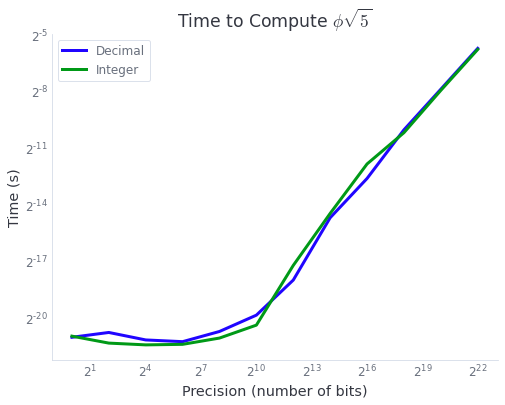

In [22]:
import timeit
import gmpy2

float_times = []
int_times = []
# use a large range of precisions by increasing exponentially
precs = 4 ** np.arange(12)
for prec in precs:
    gmpy2.get_context().precision = int(prec)
    sqrt_5 = gmpy2.sqrt(5)
    phi = 0.5 * (1 + sqrt_5)
    float_times.append(timeit.timeit(lambda: sqrt_5 * phi, number=10) / 10)
    # now use the mantissas as integers and multiply those
    sqrt_5_man = sqrt_5.as_mantissa_exp()[0]
    phi_man = phi.as_mantissa_exp()[0]
    int_times.append(timeit.timeit(lambda: sqrt_5_man * phi_man, number=10) / 10)

sns.lineplot(x=precs, y=float_times, label='Decimal')
sns.lineplot(x=precs, y=int_times, label='Integer')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.title('Time to Compute $\\phi \\sqrt{5}$')
plt.xlabel('Precision (number of bits)')
plt.ylabel('Time (s)')

The computation Binet's formula is bottlenecked by computing $\phi^n$. This requires the same number of multiplications as $M^n$, if both use repeated squaring. Computing a matrix product requires at least three integer multiplications, however.

The win for the matrix method is that you don't need all of those digits at the very start. The very first multiplication requires however many bits of precision we use for the last one in Binet's formula, but with integers the first values are small and very fast.

Which will be faster? Let's test them and find out. But there's one thing we should do first...

Our original `matrix_fib` used Python's arbitrary-size integers, which are slower than `gmpy2` by a lot. To compare Binet's formula and matrix exponentiation on an even footing, we should convert the latter to use the faster [GMP](http://gmplib.org) version, the same library that `gmpy2` uses.

Now let's see what happens when we compare them!

In [23]:
from gmpy2 import mpz

def matrix_fib(n):
    if n < 2:
        return n
    m_to_the_n = exp_by_squaring(
        lambda x, y: x @ y, # the multiplication function
        np.array([ # 2x2 identity matrix
            [mpz(1), mpz(0)],
            [mpz(0), mpz(1)]
        ], dtype=object), 
        # the matrix we're exponentiating
        np.array([
            [mpz(1), mpz(1)],
            [mpz(1), mpz(0)]
        ], dtype=object),
        n)
    
    v = np.array([[mpz(1)], [mpz(0)]])
    return (m_to_the_n @ v)[1][0]

print(matrix_fib(10_000_000) % 100_013, matrix_fib_modulo(10_000_000, 100_013))

81104 81104


In [24]:
#constellate: setup

from gmpy2 import mpz

def matrix_fib(n):
    if n < 2:
        return n
    m_to_the_n = exp_by_squaring(
        lambda x, y: x @ y, # the multiplication function
        np.array([ # 2x2 identity matrix
            [mpz(1), mpz(0)],
            [mpz(0), mpz(1)]
        ], dtype=object), 
        # the matrix we're exponentiating
        np.array([
            [mpz(1), mpz(1)],
            [mpz(1), mpz(0)]
        ], dtype=object),
        n)
    
    v = np.array([[mpz(1)], [mpz(0)]])
    return (m_to_the_n @ v)[1][0]

# matrix_fib(10_000_000) % 100_013 == matrix_fib_modulo(10_000_000, 100_013)

We can see that, practically, there's not actually much of a difference here. For small $n$ matrix multiplication is faster, as noted above, but Binet's formula doesn't manage to save much by multiplying one number instead of several each iteration. One thing I haven't mentioned is that computing $\sqrt{5}$ to the number of digits required, and computing the division and rounding, is a nontrivial part of the final runtime—for these sizes, it seems to cancel out any benefit of doing fewer multiplications. 

Surely there are still ways to improve. Perhaps there's some way to meld these approaches and do better still?

Text(0, 0.5, 'Time (s)')

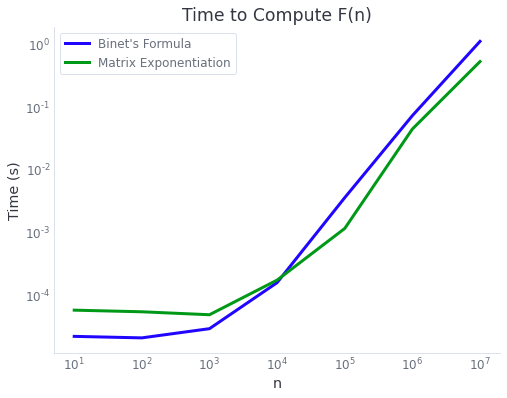

In [25]:
import timeit

binet_times = []
matrix_times = []
# use a large range of values by increasing exponentially
ns = 10 ** (np.arange(7) + 1)
for n in ns:
    binet_times.append(timeit.timeit(lambda: binet(n), number=5) / 5)
    matrix_times.append(timeit.timeit(lambda: matrix_fib(n), number=5) / 5)

sns.lineplot(x=ns, y=binet_times, label="Binet's Formula")
sns.lineplot(x=ns, y=matrix_times, label='Matrix Exponentiation')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.title('Time to Compute F(n)')
plt.xlabel('n')
plt.ylabel('Time (s)')

## The Best of Both Worlds

What if we could use Binet's formula without needing this extra precision early on? 

When you compute values involving square roots by hand, I imagine you probably wait until the end and only then pull out a calculator if you need the answer in decimal. For example, if you're computing $(1 + \sqrt{2})(3 + \sqrt{2})$, you might first just work the exact answer by expanding the product, getting $5 + 4 \sqrt{2}$, and then computing this to whatever precision you need.

We can steal this approach. In the same way that complex numbers result by adding a new element $i = \sqrt{-1}$ and all of the new numbers you can make by adding and multiplying it with the existing ones, we can imagine setting $j = \sqrt{5}$ and representing numbers as $a + bj$.

Let's write out the rules of adding and multiplying in this new number system:

$$
\gdef\zv#1#2{#1 + #2 \sqrt{5}}
\begin{aligned}
\left(\zv{a}{b}\right) + \left(\zv{c}{d}\right) &= \zv{\left(a + c\right)}{\left(b + d\right)} \\
\left(\zv{a}{b}\right) \times \left(\zv{c}{d}\right) &= ac + ad \sqrt{5} + bc \sqrt{5} + bd \sqrt{5} \sqrt{5} \\
&= \zv{(ac + 5bd)}{(ad + bc)} \\
\end{aligned}
$$

Python has a lot of features that are convenient for math. One of them is *operator overloading*, or changing how `+`, `-`, `*`, etc., work. We can use this to make numbers of the form $a + b \sqrt{5}$ easy to work with. Using this feature, we can make a custom `Z5` object (so called because the mathematical way of describing this group of numbers is $\mathbb{Z}(\sqrt{5})$) that represents one of these numbers.

If we play our cards right, we never even need to compute $\sqrt{5}$. Let's look at the full unrounded version of Binet's formula:

$$
F(n) = \frac{(1 + \sqrt{5}) ^ n - (1 - \sqrt{5})^n}{2^n \sqrt{5}}
$$

Similarly to how complex conjugates work, it turns out that $(1 - \sqrt{5})^n$ will simply be $(1 + \sqrt{5})^n$ with the sign of the $\sqrt{5}$ coefficient flipped. This is why Binet's formula always gives an integer result: the integral parts cancel, and the $\sqrt{5}$ will cleanly cancel without ever having to be computed. Dividing by powers of 2 is very simple for computers, because that's just chopping off zeros in binary. This lets us implement a new Fibonacci function, as seen opposite.[^1]

[^1]: I do some work to avoid needing a big division by $2^n$ at the end, to keep the intermediate steps smaller. It's probably more fair to say that `Z5(a, b)` represents $\frac{a}{2} + \frac{b}{2} \sqrt{5}$.

In [26]:
from gmpy2 import mpz

# One thing to note: we do some work to avoid having extra powers of 2^n. 
# Every time we multiply, we divide by 2. Then, at the end, we just 
# read off the b coefficient.
class Z5:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def _repr_latex_(self):
        return f'${self.a} + {self.b} \\sqrt{5}$'

    def __repr__(self):
        return f'Z5({self.a}, {self.b})'

    def __add__(self, other):
        return Z5(self.a + other.a, self.b + other.b)

    def __sub__(self, other):
        return Z5(self.a - other.a, self.b - other.b)

    def __mul__(self, other):
        a, b, c, d = self.a, self.b, other.a, other.b
        return Z5(
            (a * c + 5 * b * d) // 2,
            (a * d + b * c) // 2
        )

    def to_float(self):
        gmpy2.get_context().precision = self.b.bit_length() + 1
        return gmpy2.sqrt(5) * self.b + self.a


def z5_fib(n):
    if n < 2:
        return n
    
    x = exp_by_squaring(lambda x, y: x * y, Z5(mpz(2), mpz(0)), Z5(mpz(1), mpz(1)), int(n))
    return x.b

print(z5_fib(72), matrix_fib(72))
print(z5_fib(10_000_000) % 100_013, matrix_fib_modulo(10_000_000, 100_013))

498454011879264 498454011879264
81104 81104


In [27]:
#constellate: setup
from gmpy2 import mpz

# One thing to note: we do some work to avoid having extra powers of 2^n. 
# Every time we multiply, we divide by 2. Then, at the end, we just 
# read off the b coefficient.
class Z5:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def _repr_latex_(self):
        return f'${self.a} + {self.b} \\sqrt{5}$'

    def __repr__(self):
        return f'Z5({self.a}, {self.b})'

    def __add__(self, other):
        return Z5(self.a + other.a, self.b + other.b)

    def __sub__(self, other):
        return Z5(self.a - other.a, self.b - other.b)

    def __mul__(self, other):
        a, b, c, d = self.a, self.b, other.a, other.b
        return Z5(
            (a * c + 5 * b * d) // 2,
            (a * d + b * c) // 2
        )

    def to_float(self):
        gmpy2.get_context().precision = self.b.bit_length() + 1
        return gmpy2.sqrt(5) * self.b + self.a


def z5_fib(n):
    if n < 2:
        return n
    
    x = exp_by_squaring(lambda x, y: x * y, Z5(mpz(2), mpz(0)), Z5(mpz(1), mpz(1)), int(n))
    return x.b

# print(z5_fib(72), matrix_fib(72))
# print(z5_fib(10_000_000) % 100_013, matrix_fib_modulo(10_000_000, 100_013))

### Going in Circles By Speeding Up Squares

Unfortunately, this method isn't performing any better than the other two. The problem is that expanding out $\left(a + b \sqrt{5} \right) \left(c + d \sqrt{5} \right)$ requires four multiplications: each of those multiplicands are a little smaller than the numbers themselves, but not by much, and so we're still basically trading a single floating-point multiplication for several integer multiplications. The overhead of computing $\sqrt{5}$ or small inefficiencies are pretty small compared to the raw cost of doing big multiplications.

We've basically hit the limit of what powerful, abstract techniques can achieve. Closed forms can be found for many recurrences, and matrix exponentiation pops up all over the place. Techniques to compute these quickly can miss specific structure inherent to our problem. To get the fastest possible function, we need to hand-tune a specific implementation to really shine for our specific task.

Text(0, 0.5, 'Time (s)')

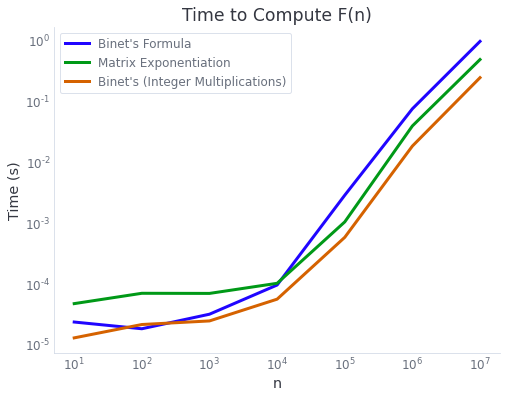

In [28]:
import timeit

binet_times = []
matrix_times = []
z5_times = []
# use a large range of values by increasing exponentially
ns = 10 ** (np.arange(7) + 1)
N_RUNS = 5
for n in ns:
    binet_times.append(timeit.timeit(lambda: binet(n), number=N_RUNS) / N_RUNS)
    matrix_times.append(timeit.timeit(lambda: matrix_fib(n), number=N_RUNS) / N_RUNS)
    z5_times.append(timeit.timeit(lambda: z5_fib(n), number=N_RUNS) / N_RUNS)

sns.lineplot(x=ns, y=binet_times, label="Binet's Formula")
sns.lineplot(x=ns, y=matrix_times, label='Matrix Exponentiation')
sns.lineplot(x=ns, y=z5_times, label="Binet's (Integer Multiplications)")
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.title('Time to Compute F(n)')
plt.xlabel('n')
plt.ylabel('Time (s)')

## Boosting Matrix Exponentiation

We're jumping several levels of abstraction: instead of thinking purely about mathematical algorithms, we're going to think about how computers work, and how we can speed up a very specific algorithm using some tricks. In applied math problems, getting the mathematical answer can be only half the battle—getting code to run efficiently on actual hardware is a different challenge. We're going to start with our matrix exponentiation algorithm and really make it sing.

Recall that matrix exponentiation means computing $M^n$, where $M = \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}$. Let's just show what the first few powers look like:

$$
\begin{aligned}
M &= \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix} \\
M^2 &= \begin{pmatrix} 2 & 1 \\ 1 & 1 \end{pmatrix} \\
M^3 &= \begin{pmatrix} 3 & 2 \\ 2 & 1 \end{pmatrix} \\
M^4 &= \begin{pmatrix} 5 & 3 \\ 3 & 2 \end{pmatrix} \\
\end{aligned}
$$

We can spot the general form by this point:[^1]

$$
M^n = \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix}
$$

[^1]: Proof left—how did you guess—as an exercise to the reader.

### The Nitty-Gritty

To make this fast, we have to know why it's slow. This usually involves measuring the program execution time and seeing what parts of it are "hot" and causing the slowdown. (It cannot be overstated how important measurement is in optimization. The only way to know what's fast and what's slow is by testing it: everything else is guesswork at best.)

I'll save you the trouble of testing this yourself: basically all of `matrix_fib`'s runtime is computing matrix exponents. Specifically, computing $M^2, M^4, M^8, \dots$, takes a long time, and depending on how many of those we need to multiply together at the end that can contribute a significant fraction of the runtime as well. Computing matrix exponents is dominated by performing multiplications.

As you probably picked up in grade school, multiplications are trickier than additions. Computing $897 + 206$ the standard way requires adding together each column of numbers, being sure to carry the 1s when necessary. Computing $897 \times 206$ the standard way requires multiplying every digit with every other digit, which is a lot more work. The grade-school method of multiplication is just one way of organizing it, but this core fact remains: note how each digit in the individual products we add to get the final product comes from the product of a pair of the original digits.[^1]

Another important fact to realize is that squaring can be significantly faster than multiplication. If we're squaring a 3-digit number, instead of 9 individual pairs of digits to multiply, we only need to multiply 6. (For $abc \times abc$, we need to compute $a \times a, a \times b, a \times c, b \times c, b^2,$ and $c^2$)

So our goal is to eliminate expensive multiplications as much as possible, and if we have to multiply ideally we square integers. How can we do that for our specific problem?

[^1]: Multiplying $n$-digit numbers in less than $n^2$ multiplications seems impossible, but in fact it's possible to do less than that. As it turns out, that's not especially relevant here, so I'm not going to talk about it that much, but if I just piqued your interest try Googling Karatsuba multiplication and go from there.

In [29]:
#constellate: ignore
#find a good example where the digits are different
import itertools
for a, b, c, d, e, f in itertools.product(range(10), repeat=6):
    abc = 100 * a + 10 * b + c
    def_ = 100 * d + 10 * e + f
    af1, af, bf, cf = f'{abc * f:4}'
    ae1, ae, be, ce = f'{abc * e:4}'
    ad1, ad, bd, cd = f'{abc * d:4}'
    digits = {af, bf, cf, af1, ae1, ae, be, ce, ad1, ad, bd, cd}
    if len(digits) == 11 and len({a, b, c, d, e, f}) == 6 and b + e == 9 and f + c >= 10 and a * d != 0:
        print(a, b, c, d, e, f, ''.join(digits))

2 6 9 1 3 5  3475819260
2 6 9 5 3 1  3745819260
3 4 7 2 5 6  3745819260
3 7 8 5 2 9  4375819260
3 7 8 9 2 5  3745819260
9 6 7 1 3 5  3475819260


In [30]:
#constellate: ignore
from IPython.display import display_latex

def addition_latex(a, b, c, d, e, f):
    cf, carry1 = (c + f) % 10, (c + f) // 10
    be, carry2 = (b + e + carry1) % 10, (b + e + carry1) // 10
    ad_full = (a + d + carry2)
    ad1, ad = ad_full // 10, ad_full % 10
    return r'''
$$
\begin{{equation*}}
\begin{{aligned}}
    & && \ctwo{{{carry2}}}\, &&\cthree{{{carry1}}}\, && \\
    & &&\cone{{{a}}}\, &&\ctwo{{{b}}}\, &&\cthree{{{c}}} \\
    &+ &&\cone{{{d}}}\, &&\ctwo{{{e}}}\, &&\cthree{{{f}}}  \\
    \hline
    &\cone{{{ad1}}} &&\cone{{{ad}}} &&\ctwo{{{be}}} &&\cthree{{{cf}}} \\
\end{{aligned}}
\end{{equation*}}
$$'''.format(a=a, b=b, c=c, d=d, e=e, f=f, 
    carry1=f'_{carry1}',
    carry2=f'_{carry2}',
    cf=cf,
    be=be,
    ad=ad,
    ad1=ad1 if ad1 else ' '
    )

def multiplication_latex(a, b, c, d, e, f):
  abc = 100 * a + 10 * b + c
  def_ = 100 * d + 10 * e + f
  af1, af, bf, cf = f'{abc * f:4}'
  ae1, ae, be, ce = f'{abc * e:4}'
  ad1, ad, bd, cd = f'{abc * d:4}'  
  ans5, ans4, ans3, ans2, ans1, ans0 = f'{abc * def_:6}'
  return r'''
$$
\begin{{equation*}}
  \begin{{aligned}}
  & && && && &&{a} &&{b} && {c} \\
  & && && &&\times&&{d} &&{e} && {f} \\
  \hline 
 & && && &&{af1} &&{af} &&{bf} &&{cf} \\
 & && &&{ae1} &&{ae} &&{be} &&{ce} &&\ \\
 & &&{ad1} &&{ad} &&{bd} &&{cd} && &&  \\
 \hline
 =&{ans5} &&{ans4} &&{ans3} &&{ans2} &&{ans1} &&{ans0} \\
  \end{{aligned}}
\end{{equation*}}
$$'''.format(**locals())


abcdef = list(map(int, '269531'))
display_latex(addition_latex(*abcdef), raw=True)
display_latex(multiplication_latex(*abcdef), raw=True)

# print(addition_latex(*abcdef), r'\\', r'\\', multiplication_latex(*abcdef), sep='\n')

#constellate: latex

$$
\begin{equation*}
\begin{aligned}
    & && \ctwo{_1}\, &&\cthree{_1}\, && \\
    & &&\cone{2}\, &&\ctwo{6}\, &&\cthree{9} \\
    &+ &&\cone{1}\, &&\ctwo{3}\, &&\cthree{5}  \\
    \hline
    &\cone{ } &&\cone{4} &&\ctwo{0} &&\cthree{4} \\
\end{aligned}
\end{equation*}
$$




$$
\begin{equation*}
  \begin{aligned}
  & && && && &&2 &&6 && 9 \\
  & && && &&\times&&1 &&3 && 5 \\
  \hline 
 & && && &&1 &&3 &&4 &&5 \\
 & && &&  &&8 &&0 &&7 &&\ \\
 & &&  &&2 &&6 &&9 && &&  \\
 \hline
 =&  &&3 &&6 &&3 &&1 &&5 \\
  \end{aligned}
\end{equation*}
$$

### Getting Acquainted

We're leaving the land of abstract, general solutions. Our goal is to compute *these* powers more quickly. Let's take a second to get acquainted.

First off, $M$ and all of its powers are special in that the upper right and lower left values are equal. This makes squaring $M$ faster than a normal matrix, because we only need to compute three values instead of four. That's already a pretty big time save. But remember, these aren't just any numbers: they're Fibonacci numbers. So we know that, because $F(n + 1) = F(n) + F(n - 1)$, we can write this in terms of only two numbers: $a = F(n - 1)$ and $b = F(n)$. 

#constellate: latex

$$
\begin{aligned}
M^n &= \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix} \\
    &= \begin{pmatrix} a + b & b \\ b & a \end{pmatrix} \\
\end{aligned}
$$

After some clever rewriting, we can square $M^n$ in only three squares, as shown below. We simply compute $(a + b)^2, a^2$, and $b^2$ and then add and multiply them together in various combinations to get the new values of the matrix.

#constellate: latex

$$
\begin{equation*}
\begin{aligned}
M^n &= \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix} \\
    &= \begin{pmatrix} a + b & b \\ b & a \end{pmatrix} \\
    \hline
M^{2n} &= \begin{pmatrix} a + b & b \\ b & a \end{pmatrix} \begin{pmatrix} a + b & b \\ b & a \end{pmatrix} \\
&= \begin{pmatrix} (a + b)^2 + b^2 & 2ab + b^2 \\ 2ab + b^2 & a^2 + b^2 \end{pmatrix} \\
&= \begin{pmatrix} (a + b)^2 + b^2 & (a + b)^2 - a^2 \\ (a + b)^2 - a^2 & a^2 + b^2 \end{pmatrix}
\end{aligned}
\end{equation*}
$$

### Determining Improvements: Cassini's Identity

Three squares is pretty good, but we can do even better!

Let's look at $M^n = \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix}$ again. There's a tool from linear algebra we can use here called the *determinant*, notated as $\det M$. I'll skip the geometric intuition behind the determinant because it's not especially relevant here, but suffice it to say that the determinant of a matrix is a number that represents how much the matrix scales its inputs.[^1] (The identity matrix has determinant 1, for example, because it preserves areas.)

Importantly, determinants play nice with multiplication: $\det AB = \det A \det B$. For a $2 \times 2$ matrix $\begin{pmatrix} a & b \\ c & d \end{pmatrix}$, the determinant is $ad - bc$.

Let's use this tool to discover a new equation that can help us out.

[^1]: For more, consult any resource on linear algebra. [Here's a good one.](https://www.youtube.com/watch?v=Ip3X9LOh2dk)

Because determinants play nice with multiplication, we can take the determinant of both sides in our equation $M^n = \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix}$ and simplify, as I've done opposite. This gives us the result known as *Cassini's identity*.

We had 
$$
\begin{aligned}
M^{2n} &= \begin{pmatrix} a + b & b \\ b & a \end{pmatrix} \begin{pmatrix} a + b & b \\ b & a \end{pmatrix} \\
&= \begin{pmatrix} (a + b)^2 + b^2 & 2ab + b^2 \\ 2ab + b^2 & a^2 + b^2 \end{pmatrix} \\
&= \begin{pmatrix} (a + b)^2 + b^2 & (a + b)^2 - a^2 \\ (a + b)^2 - a^2 & a^2 + b^2 \end{pmatrix}
\end{aligned}
$$

That the bottom right corner of this is $a^2 + b^2$ can be written as such: $F(2n - 1) = F(n)^2 + F(n - 1)^2$. Can we use Cassini's identity to rewrite one of the other cells ($F(2n)$ or $F(2n + 1)$) in a form that only requires computing $F(n)^2$ and $F(n - 1)^2$, not $F(n + 1)^2$?

#constellate: latex

$$
\begin{aligned}
M^n &= \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix} \\
\det M^n &= \det \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix} \\
(\det M)^n &= \det \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix} \\
\left(\det \begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}\right)^n &= \det \begin{pmatrix} F(n+1) & F(n) \\ F(n) & F(n-1) \end{pmatrix} \\
(1 \times 0 - 1 \times 1)^n &= F(n+1)F(n-1) - F(n)^2 \\
(-1)^n &= F(n + 1)F(n - 1) - F(n)^2 \\
\end{aligned}
$$

Yes we can! You can see the expression we get for $F(2n + 1)$ opposite.

This exploration has tried to focus on the general problem solving techniques and ideas that have led to what we've discovered so far. Most applied math problems don't have centuries of work behind them, and so even if this exploration simply retreads solved problems the strategies shown here can work well for problems without that history.

Unfortunately, if you're looking for an explanation of how this series of manipulations is natural, you have me beat. The highlighted replacement comes from Cassini's identity, and the first line comes from writing $F(2n + 1)$ as $F(2k - 1)$ with $k = n + 1$ and applying the formula for $F(2k - 1)$. I'm not sure how you'd think of doing the rest besides simply trying a lot of things.

We're almost to the conclusion of our tour through the land of Fibonacci. What remains is to use this recursion and arrive at the current state of the art for computing $F(n)$.

#constellate: latex

$$
\begin{aligned}
F(2n + 1) &= F(n + 1)^2 + F(n)^2 \\
&= (F(n) + F(n - 1))^2 + F(n)^2 \\
&= F(n)^2 + 2 F(n) F(n - 1) ++ F(n-1)^2 + F(n)^2 \\
&= 2F(n)^2 + 2(F(n+1) - F(n - 1))F(n - 1) + F(n - 1)^2 \\
&= 2F(n)^2 + 2\cone{F(n+1)F(n-1)} - 2F(n - 1)^2 + F(n - 1)^2 \\
&= 2F(n)^2 + 2\cone{(F(n)^2 + (-1)^n)} - F(n - 1)^2 \\
&= 4 F(n)^2 - F(n - 1)^2 + 2(-1)^n \\
\end{aligned}
$$

## The State of the Art

The current best algorithm for computing $F(n)$ can be summarized succinctly using the following three equations:

$$
\begin{aligned}
F(2n + 1) &= 4 F(n)^2 - F(n - 1)^2 + 2(-1)^n \\
F(2n - 1) &= F(n)^2 + F(n - 1)^2 \\
F(2n) &= F(2n + 1) - F(2n - 1)
\end{aligned}
$$

We can use these three equations to chain our way to any number we want. We start with $F(n - 1)$ and $F(n)$ where $n = 1$: these are just our base case values 0 and 1. Then, we compute all three of $F(2n - 1), F(2n), F(2n + 1)$ using just two squares. We can either take the first two of these, in which case our new index is $2n$, or the last two, in which case our new index is $2n + 1$. Either way, for our new index $n'$, we have $F(n' - 1)$ and $F(n')$, so we can apply these formulas again.

For example, to compute $F(12)$:

 - Start with $n = 1$ and our two values $(F(n - 1), F(n)) = (0, 1)$. 
 - Compute $(F(2), F(3))$: our new $n$ is $2n + 1 = 3$.
 - Compute $(F(5), F(6))$: our new $n$ is $2n = 6$.
 - Compute $(F(11), F(12))$: our new $n$ is $2n = 12$.[^1]
 - Done!

How did I know whether to go from $n$ to $2n + 1$ or $n$ to $2n$?

[^1]: For the last step, you can save a multiplication because there are direct formulas for $F(2n + 1)$ and $F(2n)$ that only require one, and because we aren't going any further we don't need the previous Fibonacci number.

### Binary Representation

There's a very clean way of figuring out which set of Fibonacci values you need. We'll show how to find the chain you want for $F(20)$ by working backwards.
 - First, write out your number in binary.
 - The last bit of the number determines whether it's odd or even. If it's even, then the chain needs to end by going from $n \rightarrow 2n$. If it's odd, the chain needs to end by going from $n \rightarrow 2n + 1$.
 - Now we know the last step of the chain. We can simply repeat this process to find the next-to-last step, and so on and so forth.
 - At the end, we simply apply that chain in order.

We always start with $n = 1$, which maps nicely to the fact that any binary number starts with a $1$. This elegant correspondence gives us exactly what we need.

#constellate: latex

$$
\begin{aligned}
20 &= 10100_2 \\
   &= 1010_2 \times 2 \\
   &= (101_2 \times 2) \times 2 \\
   &= ((10_2 \times 2 + 1) \times 2) \times 2 \\
   &= (((1 \times 2) \times 2 + 1) \times 2) \times 2\\
\end{aligned}
$$

$$
\begin{aligned}
&\ctwo{1}\ &\cone{0}\ \ & &\ctwo{1}\ \ & &\cone{0}\ \ & &\cone{0}_2\ \ &= &20 \\
&\ctwo{1} &\cone{\xrightarrow{\times 2 + 0}}& \ \ 2 &\ctwo{\xrightarrow{\times 2 + 1}}&\ \ 5 &\cone{\xrightarrow{\times 2 + 0}}&\ \ 10 &\cone{\xrightarrow{\times 2 + 0}}&\ \ &20 \\
\end{aligned}
$$

This is *fast*. Computing the billionth Fibonacci number takes less than ten seconds on my machine.[^1] Take a second to think of how far we've come!

Now that we're at the mountaintop, let me take a second to give credit where credit is due. This algorithm was, as far as I can find, first implemented in the [GNU MP](gmplib.org) library I've been using for arithmetic this whole time. I believe it is due to Kevin Ryde, and it was first added in June 2001.

The formulas are surprisingly obscure—most references don't mention them, even the ones concerned with efficiently computing Fibonacci numbers. If you've made it this far, you've learned more about Fibonacci numbers than more or less anyone. There's no reason some even faster approach isn't out there, but it's extremely difficult to imagine any improvements to the core algorithm at this point. Feel free to prove me wrong![^2]

As a final victory lap, I'll show benchmarks for all of the algorithms we've talked about and summarize what we've accomplished and learned.

[^1]: I did say ten billion in the intro, didn't I? That takes around 90 seconds on my machine.

[^2]: There are a couple things I tried that might be a good starting point for you. There are formulas you can derive for $F(3n)$, $F(4n)$, and so on: a clever rewriting trick similar to the one above might allow you to compute $F(4n)$ and the values around it with fewer than 4 squares, for example, which would be faster than doing the $F(2n)$ formula twice. There are a lot of other identities as well: [https://r-knott.surrey.ac.uk/Fibonacci/fibFormulae.html](https://r-knott.surrey.ac.uk/Fibonacci/fibFormulae.html) has a relatively long list, although there are *so many* out there. There's also definitely a lot of uncharted territory in the realm of computing Fibonacci numbers using GPUs or multiple computer cores.

In [76]:
import gmpy2

def cassini_fib(n):
    if n < 2:
        return n

    i = 1

    f_iminus1, f_i = gmpy2.mpz(0), gmpy2.mpz(1)

    # we know the first bit is a 1, so skip it
    for bit in np.binary_repr(n)[1:]:
        # the two squares we need
        f_i_squared = gmpy2.square(f_i)
        f_iminus1_squared = gmpy2.square(f_iminus1)

        # F(2n - 1) = F(n)^2 + F(n - 1)^2
        f_2iminus1 = f_i_squared + f_iminus1_squared

        # F(2n + 1) = 4F(n)^2 - F(n - 1)^2 + 2(-1)^n
        two_minus1_exp_n = 2 if i % 2 == 0 else -2
        f_2iplus1 = 4 * f_i_squared - f_iminus1_squared + two_minus1_exp_n

        # F(2n) = F(2n + 1) - F(2n - 1)
        f_2i = f_2iplus1 - f_2iminus1

        if bit == '0':
            # go from i -> 2i
            i = 2 * i
            (f_i, f_iminus1) = (f_2i, f_2iminus1)
        else:
            # go from i -> 2i + 1
            i = 2 * i + 1
            (f_i, f_iminus1) = (f_2iplus1, f_2i)


    assert i == n # we've reached n!
    return f_i

print(cassini_fib(1_000_000_000) % 100_013, matrix_fib_modulo(1_000_000_000, 100_013))

82862 82862


## Comparing Our Solutions

Python is not a very fast programming language, and it makes it hard to write efficient code, so I've written all of the algorithms here in Rust to compare them against each other. [This repository](https://github.com/nicholas-miklaucic/fast_fib_rs) contains all of my implementations. They're by no means the most efficient possible implementations of each one, but they're good enough to provide a basis for comparison.

Opposite we have all of the algorithms and how well they did. Let's go through them one by one:

 - The naïve approach (no tail-call optimization) is slow as molasses. 
 - The memoized recursive approach and dynamic programming (DP) are essentially the same algorithm, but dynamic programming saves having to constantly check whether we've already computed a given Fibonacci number and uses less space. That makes it more efficient, but as you can see they both still scale poorly.
 - Matrix exponentiation was our first algorithm that could compute $F(n)$ in less than $n$ operations—it's where we really got cooking. Note how this and all of the future algorithms have a characteristic hooked shape. In terms of the number of multiplications, all of these algorithms are using on the order of $\log n$ operations, which looks like the tapering-off curve before around $10^3$. The problem is that, as we get larger and larger, the time to multiply numbers grows too. Once we stop being able to use the very efficient hardware instructions to multiply numbers on a CPU, and once the memory usage of reading in these large numbers becomes significant, each multiplication becomes more expensive than the last and the runtimes start to increase exponentially.
 - Binet's formula (the version using arbitrary-precision floating point arithmetic) is the slowest of these algorithms due to the extra costs associated with computing $\sqrt{5}$ and the need to carry all of the digits through the entire computation. Another important slowdown that this shares with matrix exponentiation is that, once you've computed the powers, you need to go through and multiply together the correct powers of 2 to get the answer: it requires 1 square for every bit of $n$ and 1 additional multiplication for every bit that's a 1.
 - The version of Binet that uses integer arithmetic requires three multiplications for every bit of $n$, using a trick to save the fourth multiplication that's similar to the rewriting we did of the matrix powers. This makes it the fastest of the previous approaches, but to get faster we have to cut out the extra work associated with exponentiation by squaring.
 - The first version to do that is what I've called *Efficient Matrix Exponentiation*. This is the approach that uses three squares per bit of $n$ that we derived by rewriting $M^{2n}$, but before the last optimization that only needs two squares to do the same. It's therefore slightly slower than the next two.
 - *GMP Algorithm Port* applies that last optimization, so it only uses two squares per bit of $n$.
 - Lastly, *GMP* directly calls GMP's Fibonacci function. It's a little faster than my implementation because it stores a table for the early values (as you can see by how fast it is for the starting numbers compared to the port) and saves a multiplication on the last step, but as you can see the performance is near-identical.

In [1]:
import json
import textwrap

def spread(x, dmin):
    """Returns a shifted x' with minimum total shift such that no two points in x' are within dmin.
    If dmin is array-like, it must be the same shape as x, and notes the minimum space each element
    must have on either side."""
    x = np.array(x, copy=False)
    if len(x) <= 1:
        return x
    
    # we need to work on sorted x, but we also need to remember the indices so we can adjust the right ones
    sort_inds = np.argsort(x)
    x_sort = x.copy()[sort_inds]

    dmin = np.broadcast_to(dmin, x.shape)[sort_inds]

    # Algorithms for Minimizing the Movements of Spreading Points in Linear Domains
    # Li, Wang 2015
    # https://cccg.ca/proceedings/2015/08.pdf

    # first pass: fix first element, only move to right
    adj = np.zeros_like(x_sort, dtype=np.float64)
    for i in range(1, len(x_sort)):
        # previous element's new location is x_sort[i-1] + adj[i-1]
        # move to max(x_sort[i], prev + dmin)

        # dmin = max(dmin[i], dmin[i-1])

        local_dmin = max(dmin[i], dmin[i-1])
        prev = x_sort[i-1] + adj[i-1]
        new_x = max(x_sort[i], prev + local_dmin)
        adj[i] = new_x - x_sort[i]

    # Li, Wang now moves everything left by half the max movement
    # this produces the minimum maximum shift
    # alternatively, we subtract by the median, which minimizes the sum of shifts
    # subtracting by mean minimizes the sum of squares of shifts
    # adj -= np.max(adj) / 2
    adj -= np.median(adj)

    # now adjust, going back to indices of original matrix
    return x + adj[np.argsort(sort_inds)]

spread([1, 2, 8, 9, 10], np.arange(5) + 1)

data = []
with open('/home/nicholas/programs/fast_fib/benchmarks.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df = df.query('reason == "benchmark-complete"')
df = df[['id', 'iteration_count', 'measured_values']]
df[['group', 'algorithm', 'n']] = df['id'].str.split('/', expand=True)
df['n'] = df['n'].astype(int)
df = df.explode(['iteration_count', 'measured_values'])
# convert from ns to s
df['measured_values'] /= 1_000_000_000
df['time'] = (df['measured_values'] / df['iteration_count']).astype(float)
df['log_time'] = np.log10(df['time'])
df['log_n'] = np.log10(df['n'])
df = df.reset_index(drop=True)

from scipy import stats
gdf = []

for (alg, n), inds in df.groupby(['algorithm', 'n']).groups.items():
    subs = df.loc[inds]

    mid, (lo, hi) = stats.bayes_mvs(subs['time'], alpha=0.95)[0]
    gdf.append((alg, n, mid, lo, hi))

gdf = pd.DataFrame(data=gdf, columns=['algorithm', 'n', 'time', 'lo', 'hi'])

fig, ax = plt.subplots(figsize=(13, 8))

algs = gdf.groupby('algorithm').max()['time'].sort_values().index[::-1]

alg_labels = np.array(['\n'.join(textwrap.wrap(alg, width=20)) for alg in algs])

ax.set_xscale('log')
ax.set_yscale('log')
right = gdf['n'].max()
top = gdf['time'].max()
margin = 3

right = right * (10 ** margin) if ax.get_xscale() == 'log' else right + margin
top = top * (10 ** margin) if ax.get_yscale() == 'log' else top + margin

ax.set_xlim(gdf['n'].min(), right)
ax.set_ylim(gdf['time'].min(), top)

import matplotlib 

def height(text, **kwargs):
    t = matplotlib.textpath.TextPath((0,0), text, **kwargs)
    bb = t.get_extents().transformed(fig.dpi_scale_trans.inverted())
    return bb.height

dmin = np.array([height(label) for label in alg_labels]) * 2

ys = gdf.groupby('algorithm').max()['time'][algs]
# we need some x coordinates to transform, these should be OK
# no guarantee these match the ys, but assuming Cartesian layout
# so y transform should be independent of x, just need a valid value
xs = gdf.groupby('algorithm').max()['n'][ys.index]

from matplotlib.transforms import CompositeGenericTransform

# do separation in figure inches space
data_to_fig_in = CompositeGenericTransform(ax.transData, fig.dpi_scale_trans.inverted())

xy_trans = data_to_fig_in.transform(np.vstack([xs.values, ys.values]).T)
x_unspreaded, y_unspreaded = xy_trans.T
y_spreaded = spread(y_unspreaded, dmin=dmin)

ys = pd.Series(index=ys.index, data=data_to_fig_in.inverted().transform(np.vstack([x_unspreaded, y_spreaded]).T)[:, 1])

for alg, label, color in zip(algs, alg_labels, cs):
    subs = gdf[gdf['algorithm'] == alg]
    ax.plot(subs['n'], subs['time'], c=color, label=alg, lw=1.5)

    xmax = subs['n'].max()
    ymax = subs['time'].max()
    ylabel = ys[alg]
    ax.plot((xmax, right), (ymax, ylabel), '--', color=color, lw=0.5, dashes=(10, 10))        
    ax.text(right, ylabel, textwrap.indent(label, ' ' * 1), ha='left', va='center', color=color)


# ax.legend().set_title('Algorithm')
ax.set_title('Running Time Comparison')
ax.set_xlabel('Fibonacci Number')
ax.set_ylabel('Time (s)', rotation='horizontal', ha='right')

NameError: name 'pd' is not defined

## Epilogue

As you are very well aware of by now if you're reading this, the problem of computing Fibonacci numbers is far deeper than it might first appear. Although you probably aren't going to need the ten billionth Fibonacci number any time soon, there's a lot of useful takeaways that will serve you well in your future mathematical endeavors:

 - Memoization and dynamic programming are fantastic tools when simple recursive approaches waste effort.
 - Recursion and iteration are equivalent: it's possible to rewrite one in terms of the other. In most common programming languages, iteration is faster.
 - Computers don't store infinite precision, and rounding errors can be a serious concern when doing computations with large numbers.
 - Linear algebra can provide invaluable tools for your toolbox: phrasing problems in terms of linear algebra often lets you stand on the shoulders of giants and borrow very well-optimized code to solve your problem, or simply borrow existing theory to gain new insights.
 - Once you have an abstract solution, there are often significant gains to be made by exploiting specific features of your exact problem, losing that generality for bespoke optimizations.
 - Mathematics permeates the world around us—profound structure lurks behind even the most innocuous sequences.

I hope you've found this enjoyable. Thanks for reading!

#constellate: ignore
- addition chains can often be 2x smaller than the simple binary method
- https://r-knott.surrey.ac.uk/Fibonacci/fibFormulae.html#section5.1

Going from an arbitrary chain in three multiplications:
$$
\begin{aligned}
F(n + m - 1) &= F(m) F(n) + F(m - 1) F(n - 1) \\
F(n + m + 1) &= F(m + 1) F(n + 1) + F(m) F(n) \\
\end{aligned}
$$

 - GMP uses just 2, and they're squares (which are faster than normal multiplications), but often m << n or vice versa
 - When $n = m$, $F(2n-1) = F((n-1)+(n-1)+1) = F(n)^2 + F(n-1)^2$ and $F(2n + 1) = F(n + 1)^2 + F(n)^2$
 - Then, $F(n + 1)^2 = 3 F(n) ^2 - 2(-1)^n + F(n-1)^2$, so $F(2n + 1) = 4 F(n)^2 + F(n - 1)^2 + 2(-1)^n$
 - No general formula for $F(n + 1) F(m + 1)$ that doesn't require an additional multiplication
 - Because doubling is more efficient, and adding 1 is too, it seems like the binary method will generally be optimal
 - Possible counterexamples: subtracting 1 at times, 